![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

# Train Legal NER

In [0]:
from johnsnowlabs import nlp, legal

#🔎 CoNLL Data Prep

In [0]:
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/legal-nlp/data/conll_noO.conll -O conll_legal.conll
dbutils.fs.cp("file:/databricks/driver/conll_legal.conll", "dbfs:/") 

Out[3]: True

In [0]:
with open("conll_legal.conll") as f:
    train_txt =f.read()

print(train_txt[:500])

Exhibit NN NN O
10.6 NN NN O
memorandum NN NN B-DOC
Between NN NN O
(hereinafter NN NN B-PARTY
collectively NN NN I-PARTY
called NN NN I-PARTY
"Parties" NN NN I-PARTY
and NN NN I-PARTY
individually NN NN I-PARTY
called NN NN I-PARTY
"Party"), NN NN I-PARTY
And NN NN O
MBE NN NN B-PARTY

ARTICLE NN NN O
II NN NN O
ENGAGEMENT NN NN O
OF NN NN O
ZEBRA NN NN B-PARTY
BRAZIL NN NN I-PARTY
6 NN NN O

ARTICLE NN NN O
II NN NN O
ENGAGEMENT NN NN O
OF NN NN O
ZEBRA NN NN B-PARTY
BRAZIL NN NN I-PARTY
6 NN

In [0]:
from sparknlp.training import CoNLL

training_data = CoNLL().readDataset(spark, 'file:/dbfs/conll_legal.conll')

training_data.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
 text| document| sentence| token| pos| label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
Exhibit 10.6 memo...|[{document, 0, 11...|[{document, 0, 11...|[{token, 0, 6, Ex...|[{pos, 0, 6, NN, ...|[{named_entity, 0...|
ARTICLE II ENGAGE...|[{document, 0, 38...|[{document, 0, 38...|[{token, 0, 6, AR...|[{pos, 0, 6, NN, ...|[{named_entity, 0...|
ARTICLE II ENGAGE...|[{document, 0, 38...|[{document, 0, 38...|[{token, 0, 6, AR...|[{pos, 0, 6, NN, ...|[{named_entity, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows

In [0]:
training_data.printSchema()

root
-- text: string (nullable = true)
-- document: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- sentence: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- token: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- pos: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- label: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)

In [0]:
%time training_data.count()

CPU times: user 8.99 ms, sys: 2 ms, total: 11 ms
Wall time: 2.25 s
Out[7]: 5022

In [0]:
import pyspark.sql.functions as F

training_data.select(F.explode(F.arrays_zip(training_data.token.result, 
                                            training_data.pos.result, 
                                            training_data.label.result)).alias("cols")) \
             .select(F.expr("cols['0']").alias("token"),
                     F.expr("cols['1']").alias("pos"),
                     F.expr("cols['2']").alias("ner_label")).show(truncate=50)

+------------+---+---------+
 token|pos|ner_label|
+------------+---+---------+
 Exhibit| NN| O|
 10.6| NN| O|
 memorandum| NN| B-DOC|
 Between| NN| O|
(hereinafter| NN| B-PARTY|
collectively| NN| I-PARTY|
 called| NN| I-PARTY|
 "Parties"| NN| I-PARTY|
 and| NN| I-PARTY|
individually| NN| I-PARTY|
 called| NN| I-PARTY|
 "Party"),| NN| I-PARTY|
 And| NN| O|
 MBE| NN| B-PARTY|
 ARTICLE| NN| O|
 II| NN| O|
 ENGAGEMENT| NN| O|
 OF| NN| O|
 ZEBRA| NN| B-PARTY|
 BRAZIL| NN| I-PARTY|
+------------+---+---------+
only showing top 20 rows

In [0]:
training_data.select(F.explode(F.arrays_zip(training_data.token.result,
                                            training_data.label.result)).alias("cols")) \
             .select(F.expr("cols['0']").alias("token"),
                     F.expr("cols['1']").alias("ground_truth")).groupBy('ground_truth').count().orderBy('count', ascending=False).show(100,truncate=False)

+------------+-----+
ground_truth|count|
+------------+-----+
O |71670|
I-PARTY |12097|
B-PARTY |5804 |
I-DOC |3203 |
B-DOC |2007 |
B-DATE |1796 |
B-LAW |782 |
B-ROLE |316 |
B-LOC |259 |
B-ORDINAL |151 |
B-PERCENT |136 |
B-PERSON |92 |
I-EFFDATE |33 |
B-EFFDATE |18 |
+------------+-----+

#🔎 Using RoBerta Embeddings

In [0]:
%fs mkdirs file:/dbfs/ner_logs

res0: Boolean = true

In [0]:
roberta_embeddings = nlp.RoBertaEmbeddings.pretrained("roberta_embeddings_legal_roberta_base","en") \
    .setInputCols(["sentence", "token"]) \
    .setOutputCol("embeddings") \
    .setMaxSentenceLength(512)

roberta_embeddings_legal_roberta_base download started this may take some time.
Approximate size to download 447.2 MB
[ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][OK!]

In [0]:
nerTagger = legal.NerApproach()\
              .setInputCols(["sentence", "token", "embeddings"])\
              .setLabelColumn("label")\
              .setOutputCol("ner")\
              .setMaxEpochs(3)\
              .setLr(0.003)\
              .setBatchSize(32)\
              .setRandomSeed(0)\
              .setVerbose(1)\
              .setValidationSplit(0.2)\
              .setEvaluationLogExtended(True) \
              .setEnableOutputLogs(True)\
              .setIncludeConfidence(True)\
              .setOutputLogsPath('dbfs:/ner_logs') # if not set, logs will be written to ~/annotator_logs
        #    .setGraphFolder('graphs') >> put your graph file (pb) under this folder if you are using a custom graph generated thru 4.1 NerDL-Graph.ipynb notebook
        #    .setEnableMemoryOptimizer() >> if you have a limited memory and a large conll file, you can set this True to train batch by batch 
    
ner_pipeline = nlp.Pipeline(stages=[
                                nerTagger
                                ])


In [0]:
roberta_embeddings.transform(training_data).write.mode('overwrite').parquet('dbfs/legal_train_roberta.parquet')

In [0]:
train_embeddings = spark.read.parquet('/dbfs/legal_train_roberta.parquet')

In [0]:
%%time

ner_model = ner_pipeline.fit(train_embeddings)

# if you get an error for incompatible TF graph, use 4.1 NerDL-Graph.ipynb notebook to create a graph (or see the bottom cell of this notebook)

CPU times: user 433 ms, sys: 226 ms, total: 659 ms
Wall time: 2min 13s

In [0]:
import os

log_files = os.listdir("/dbfs/ner_logs")
with open("/dbfs/ner_logs/"+log_files[1]) as log_file:
    print(log_file.read())

Name of the selected graph: medical-ner-dl/blstm_38_768_128_200.pb
Training started - total epochs: 2 - lr: 0.003 - batch size: 32 - labels: 22 - chars: 98 - training examples: 1309


Epoch 1/2 started, lr: 0.003, dataset size: 1309


Epoch 1/2 - 87.32s - loss: 1235.7043 - avg training loss: 38.61576 - batches: 32
Quality on validation dataset (20.0%), validation examples = 261
time to finish evaluation: 69.09s
Total validation loss: 118.0434	Avg validation loss: 11.8043
label tp fp fn prec rec f1
I-AMOUNT 202 1 11 0.9950739 0.9483568 0.97115386
B-AMOUNT 256 7 11 0.973384 0.9588015 0.96603775
B-DATE 132 20 183 0.8684211 0.41904762 0.5653105
I-DATE 197 10 86 0.9516908 0.69611305 0.8040817
I-EXPENSE 0 0 37 0.0 0.0 0.0
B-PROFIT_INCREASE 0 0 33 0.0 0.0 0.0
B-EXPENSE 0 0 23 0.0 0.0 0.0
I-PERCENTAGE 0 0 2 0.0 0.0 0.0
I-PROFIT_DECLINE 0 0 12 0.0 0.0 0.0
I-PROFIT 0 0 36 0.0 0.0 0.0
B-CURRENCY 265 3 0 0.98880595 1.0 0.9943714
I-PROFIT_INCREASE 0 0 56 0.0 0.0 0.0
B-PROFIT 0 0 22 0.0 0.0 0.0
B-PERCENTAGE 30 1 31 0.9677419 0.4918033 0.65217394
I-FISCAL_YEAR 319 239 6 0.5716846 0.9815385 0.72253674
B-PROFIT_DECLINE 0 0 11 0.0 0.0 0.0
B-EXPENSE_INCREASE 1 0 53 1.0 0.018518519 0.036363635
B-EXPENSE_DECREASE 4 9 33 0.30769232 0.10810811 0.16
B-FISCAL_YEAR 101 19 8 0.84166664 0.9266055 0.8820961
I-EXPENSE_DECREASE 20 44 57 0.3125 0.25974026 0.28368795
I-EXPENSE_INCREASE 1 0 111 1.0 0.008928572 0.017699117
tp: 1528 fp: 353 fn: 822 labels: 21
Macro-average prec: 0.4656505, rec: 0.3246458, f1: 0.3825691
Micro-average prec: 0.8123339, rec: 0.65021276, f1: 0.7222879


Epoch 2/2 started, lr: 0.0029850747, dataset size: 1309


Epoch 2/2 - 86.36s - loss: 390.5025 - avg training loss: 12.203203 - batches: 32
Quality on validation dataset (20.0%), validation examples = 261
time to finish evaluation: 68.24s
Total validation loss: 70.4153	Avg validation loss: 7.0415
label tp fp fn prec rec f1
I-AMOUNT 205 2 8 0.99033815 0.9624413 0.97619045
B-AMOUNT 267 5 0 0.9816176 1.0 0.99072355
B-DATE 260 33 55 0.887372 0.82539684 0.8552632
I-DATE 254 50 29 0.8355263 0.8975265 0.86541736
I-EXPENSE 0 0 37 0.0 0.0 0.0
B-PROFIT_INCREASE 8 4 25 0.6666667 0.24242425 0.35555556
B-EXPENSE 0 0 23 0.0 0.0 0.0
I-PERCENTAGE 0 0 2 0.0 0.0 0.0
I-PROFIT_DECLINE 0 0 12 0.0 0.0 0.0
I-PROFIT 0 0 36 0.0 0.0 0.0
B-CURRENCY 265 3 0 0.98880595 1.0 0.9943714
I-PROFIT_INCREASE 28 13 28 0.68292683 0.5 0.57731956
B-PROFIT 0 0 22 0.0 0.0 0.0
B-PERCENTAGE 56 2 5 0.9655172 0.91803277 0.9411765
I-FISCAL_YEAR 318 51 7 0.86178863 0.97846156 0.9164265
B-PROFIT_DECLINE 0 0 11 0.0 0.0 0.0
B-EXPENSE_INCREASE 1 4 53 0.2 0.018518519 0.033898305
B-EXPENSE_DECREASE 16 36 21 0.30769232 0.43243244 0.35955057
B-FISCAL_YEAR 106 19 3 0.848 0.9724771 0.9059829
I-EXPENSE_DECREASE 55 135 22 0.28947368 0.71428573 0.41198504
I-EXPENSE_INCREASE 0 2 112 0.0 0.0 0.0
tp: 1839 fp: 359 fn: 511 labels: 21
Macro-average prec: 0.45265356, rec: 0.4505713, f1: 0.45161003
Micro-average prec: 0.8366697, rec: 0.7825532, f1: 0.8087071

![image.png](/files/FINLEG/metrics.png)

###📖 Splitting Dataset Into Train and Test Set

Also we will use `.setTestDataset('ner_dl_test.parquet')` for checking test-loss values of each epoch in the logs file and `.useBestModel(True)` parameter whether to restore and use the model that has achieved the best performance at the end of the training. .

In [0]:
from sparknlp.training import CoNLL

conll_data = CoNLL().readDataset(spark, 'file:/dbfs/conll_legal.conll')

(train_data, test_data) = conll_data.randomSplit([0.7, 0.3], seed = 100)

print("Training Dataset Count: " + str(train_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 3458
Test Dataset Count: 1564

In [0]:
roberta_embeddings.transform(train_data).write.mode('overwrite').parquet('dbfs/legal_trainining.parquet')
roberta_embeddings.transform(test_data).write.mode('overwrite').parquet('dbfs/legal_test.parquet')

In [0]:
train_embeddings = spark.read.parquet('/dbfs/legal_trainining.parquet')
test_embeddings = spark.read.parquet('/dbfs/legal_test.parquet')

In [0]:
%fs
mkdirs file:/dbfs/ner_logs_best

res1: Boolean = true

In [0]:
%%time

nerTagger = legal.NerApproach()\
              .setInputCols(["sentence", "token", "embeddings"])\
              .setLabelColumn("label")\
              .setOutputCol("ner")\
              .setMaxEpochs(3)\
              .setLr(0.003)\
              .setBatchSize(32)\
              .setRandomSeed(0)\
              .setVerbose(1)\
              .setValidationSplit(0.2)\
              .setEvaluationLogExtended(True) \
              .setEnableOutputLogs(True)\
              .setIncludeConfidence(True)\
              .setUseBestModel(True)\
              .setTestDataset('/dbfs/legal_test.parquet')\
              .setOutputLogsPath('dbfs:/ner_logs_best') # if not set, logs will be written to ~/annotator_logs

ner_pipeline = nlp.Pipeline(stages=[
                                nerTagger
                                ])


ner_model = ner_pipeline.fit(train_embeddings)

CPU times: user 379 ms, sys: 211 ms, total: 590 ms
Wall time: 1min 59s

In [0]:
log_files = os.listdir("/dbfs/ner_logs_best/")
log_files

Out[20]: ['FinanceNerApproach_8d9846228178.log',
 'LegalNerApproach_577b8aee517f.log',
 'LegalNerApproach_c983553785ad.log']

In [0]:
with open("/dbfs/ner_logs_best/"+log_files[0]) as log_file:
    print(log_file.read())

Name of the selected graph: medical-ner-dl/blstm_38_768_128_200.pb
Training started - total epochs: 2 - lr: 0.002 - batch size: 32 - labels: 22 - chars: 98 - training examples: 1309


Epoch 1/2 started, lr: 0.002, dataset size: 1309


Epoch 1/2 - 91.73s - loss: 1374.4897 - avg training loss: 33.52414 - batches: 41
Quality on test dataset: 
time to finish evaluation: 9.84s
Total test loss: 108.8588	Avg test loss: 9.8963
label tp fp fn prec rec f1
I-AMOUNT 227 3 9 0.98695654 0.9618644 0.97424895
B-AMOUNT 293 5 9 0.9832215 0.9701987 0.9766667
B-DATE 126 8 239 0.9402985 0.3452055 0.50501
I-DATE 335 38 65 0.8981233 0.8375 0.86675286
I-EXPENSE 0 0 74 0.0 0.0 0.0
B-PROFIT_INCREASE 3 0 27 1.0 0.1 0.18181819
B-EXPENSE 0 0 32 0.0 0.0 0.0
I-PROFIT_DECLINE 0 0 17 0.0 0.0 0.0
I-PROFIT 0 0 24 0.0 0.0 0.0
B-CURRENCY 300 3 2 0.990099 0.9933775 0.9917355
I-PROFIT_INCREASE 0 0 62 0.0 0.0 0.0
B-PROFIT 0 0 11 0.0 0.0 0.0
B-PERCENTAGE 36 0 19 1.0 0.6545454 0.79120874
I-FISCAL_YEAR 342 183 16 0.6514286 0.95530725 0.774632
B-PROFIT_DECLINE 0 0 12 0.0 0.0 0.0
B-EXPENSE_INCREASE 1 0 41 1.0 0.023809524 0.046511628
B-EXPENSE_DECREASE 0 0 37 0.0 0.0 0.0
B-FISCAL_YEAR 114 18 5 0.8636364 0.9579832 0.90836656
I-EXPENSE_DECREASE 25 50 58 0.33333334 0.30120483 0.3164557
I-EXPENSE_INCREASE 5 6 80 0.45454547 0.05882353 0.104166664
tp: 1807 fp: 314 fn: 839 labels: 20
Macro-average prec: 0.505082, rec: 0.35799098, f1: 0.41900235
Micro-average prec: 0.8519566, rec: 0.6829176, f1: 0.75812876


Epoch 2/2 started, lr: 0.0019900498, dataset size: 1309


Epoch 2/2 - 90.86s - loss: 453.42462 - avg training loss: 11.059137 - batches: 41
Quality on test dataset: 
time to finish evaluation: 9.05s
Total test loss: 72.4228	Avg test loss: 6.5839
label tp fp fn prec rec f1
I-AMOUNT 231 2 5 0.99141634 0.9788136 0.9850747
B-AMOUNT 301 5 1 0.9836601 0.9966887 0.99013156
B-DATE 244 5 121 0.9799197 0.66849315 0.7947883
I-DATE 360 21 40 0.9448819 0.9 0.921895
I-EXPENSE 0 0 74 0.0 0.0 0.0
B-PROFIT_INCREASE 8 2 22 0.8 0.26666668 0.4
B-EXPENSE 0 0 32 0.0 0.0 0.0
I-PROFIT_DECLINE 0 0 17 0.0 0.0 0.0
I-PROFIT 0 0 24 0.0 0.0 0.0
B-CURRENCY 300 3 2 0.990099 0.9933775 0.9917355
I-PROFIT_INCREASE 41 16 21 0.71929824 0.66129035 0.68907565
B-PROFIT 0 0 11 0.0 0.0 0.0
B-PERCENTAGE 55 1 0 0.98214287 1.0 0.99099094
I-FISCAL_YEAR 342 50 16 0.872449 0.95530725 0.912
B-PROFIT_DECLINE 0 0 12 0.0 0.0 0.0
B-EXPENSE_INCREASE 8 7 34 0.53333336 0.1904762 0.2807018
B-EXPENSE_DECREASE 11 16 26 0.4074074 0.2972973 0.34375
B-FISCAL_YEAR 113 11 6 0.91129035 0.94957983 0.9300412
I-EXPENSE_DECREASE 58 150 25 0.27884614 0.6987952 0.39862543
I-EXPENSE_INCREASE 0 0 85 0.0 0.0 0.0
tp: 2072 fp: 289 fn: 574 labels: 20
Macro-average prec: 0.51973724, rec: 0.47783932, f1: 0.4979084
Micro-average prec: 0.87759423, rec: 0.7830688, f1: 0.8276413

In [0]:
predictions = ner_model.transform(test_embeddings)

from sklearn.metrics import classification_report

preds_df = predictions.select(F.explode(F.arrays_zip(predictions.token.result,
                                                     predictions.label.result,
                                                     predictions.ner.result)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("token"),
                              F.expr("cols['1']").alias("ground_truth"),
                              F.expr("cols['2']").alias("prediction")).toPandas()


In [0]:
print(classification_report(preds_df['ground_truth'], preds_df['prediction'], digits=4))

precision recall f1-score support

 B-DATE 0.8389 0.7957 0.8167 602
 B-DOC 0.8962 0.7116 0.7933 631
 B-EFFDATE 0.0000 0.0000 0.0000 6
 B-LAW 0.8011 0.6812 0.7363 207
 B-LOC 0.4272 0.6286 0.5087 70
 B-ORDINAL 1.0000 0.7593 0.8632 54
 B-PARTY 0.8500 0.7025 0.7692 1815
 B-PERCENT 1.0000 0.8750 0.9333 32
 B-PERSON 0.0000 0.0000 0.0000 30
 B-ROLE 0.8395 0.7010 0.7640 97
 I-DOC 0.9122 0.8180 0.8625 978
 I-EFFDATE 0.0000 0.0000 0.0000 11
 I-PARTY 0.9141 0.9615 0.9372 3797
 O 0.9551 0.9748 0.9649 22181

 accuracy 0.9373 30511
 macro avg 0.6739 0.6149 0.6392 30511
weighted avg 0.9349 0.9373 0.9351 30511

In [0]:
from sklearn.metrics import classification_report

predictions.select(F.explode(F.arrays_zip(predictions.token.result,
                                                     predictions.label.result,
                                                     predictions.ner.result)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("token"),
                              F.expr("cols['1']").alias("ground_truth"),
                              F.expr("cols['2']").alias("prediction")).show(truncate=False)



+-------------+------------+----------+
token |ground_truth|prediction|
+-------------+------------+----------+
" |O |O |
Cart |O |O |
" |O |O |
- |O |O |
It |O |O |
is |O |O |
a |O |O |
type |O |O |
of |O |O |
Rubicon |B-PARTY |B-PARTY |
Software |I-PARTY |I-PARTY |
Group |I-PARTY |I-PARTY |
plc |I-PARTY |I-PARTY |
("Rubicon") |I-PARTY |I-PARTY |
Unit |O |O |
which |O |O |
is |O |O |
free-standing|O |O |
and |O |O |
sells |O |O |
+-------------+------------+----------+
only showing top 20 rows

###📌 Entity level evaluation (strict eval)

In [0]:
!wget  -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/open-source-nlp/utils/conll_eval.py
dbutils.fs.cp("file:/databricks/driver/conll_eval.py", "dbfs:/") 
spark.sparkContext.addPyFile("/dbfs/conll_eval.py")

In [0]:
import conll_eval

metrics = conll_eval.evaluate(preds_df['ground_truth'].values, preds_df['prediction'].values)

processed 30511 tokens with 3544 phrases; found: 3081 phrases; correct: 2404.
accuracy: 83.75%; (non-O)
accuracy: 93.73%; precision: 78.03%; recall: 67.83%; FB1: 72.57
 DATE: precision: 83.89%; recall: 79.57%; FB1: 81.67 571
 DOC: precision: 80.00%; recall: 65.93%; FB1: 72.28 520
 EFFDATE: precision: 0.00%; recall: 0.00%; FB1: 0.00 0
 LAW: precision: 80.11%; recall: 68.12%; FB1: 73.63 176
 LOC: precision: 42.72%; recall: 62.86%; FB1: 50.87 103
 ORDINAL: precision: 100.00%; recall: 75.93%; FB1: 86.32 41
 PARTY: precision: 76.04%; recall: 65.40%; FB1: 70.32 1561
 PERCENT: precision: 100.00%; recall: 87.50%; FB1: 93.33 28
 PERSON: precision: 0.00%; recall: 0.00%; FB1: 0.00 0
 ROLE: precision: 83.95%; recall: 70.10%; FB1: 76.40 81

In [0]:
# micro, macro, avg
metrics[0]

Out[27]: (78.02661473547549, 67.83295711060948, 72.57358490566037)

In [0]:
import pandas as pd

pd.DataFrame(metrics[1], columns=['entity','precision','recall','f1','support'])

Out[28]:

,entity,precision,recall,f1,support
0,DATE,83.887916,79.568106,81.670929,571
1,DOC,80.000000,65.927100,72.284970,520
2,EFFDATE,0.000000,0.000000,0.000000,0
3,LAW,80.113636,68.115942,73.629243,176
4,LOC,42.718447,62.857143,50.867052,103
5,ORDINAL,100.000000,75.925926,86.315789,41
6,PARTY,76.040999,65.399449,70.319905,1561
7,PERCENT,100.000000,87.500000,93.333333,28
8,PERSON,0.000000,0.000000,0.000000,0
9,ROLE,83.950617,70.103093,76.404494,81


###📌 Ner log parser

In [0]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/open-source-nlp/utils/ner_log_parser.py

dbutils.fs.cp("file:/databricks/driver/ner_log_parser.py", "dbfs:/") 
spark.sparkContext.addPyFile("/dbfs/ner_log_parser.py")

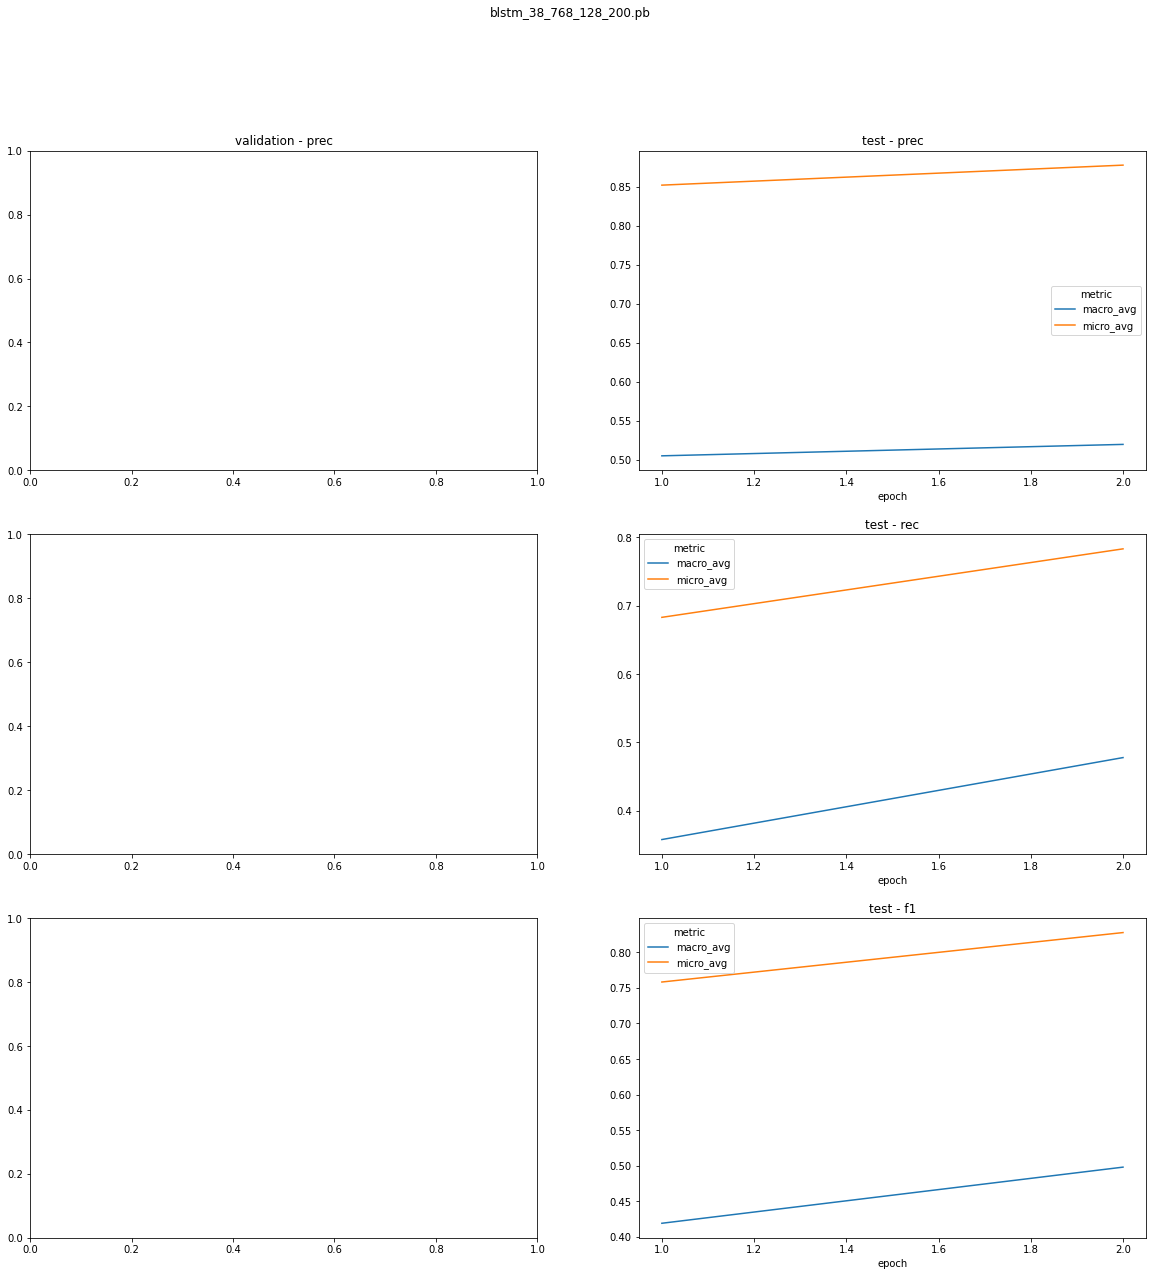

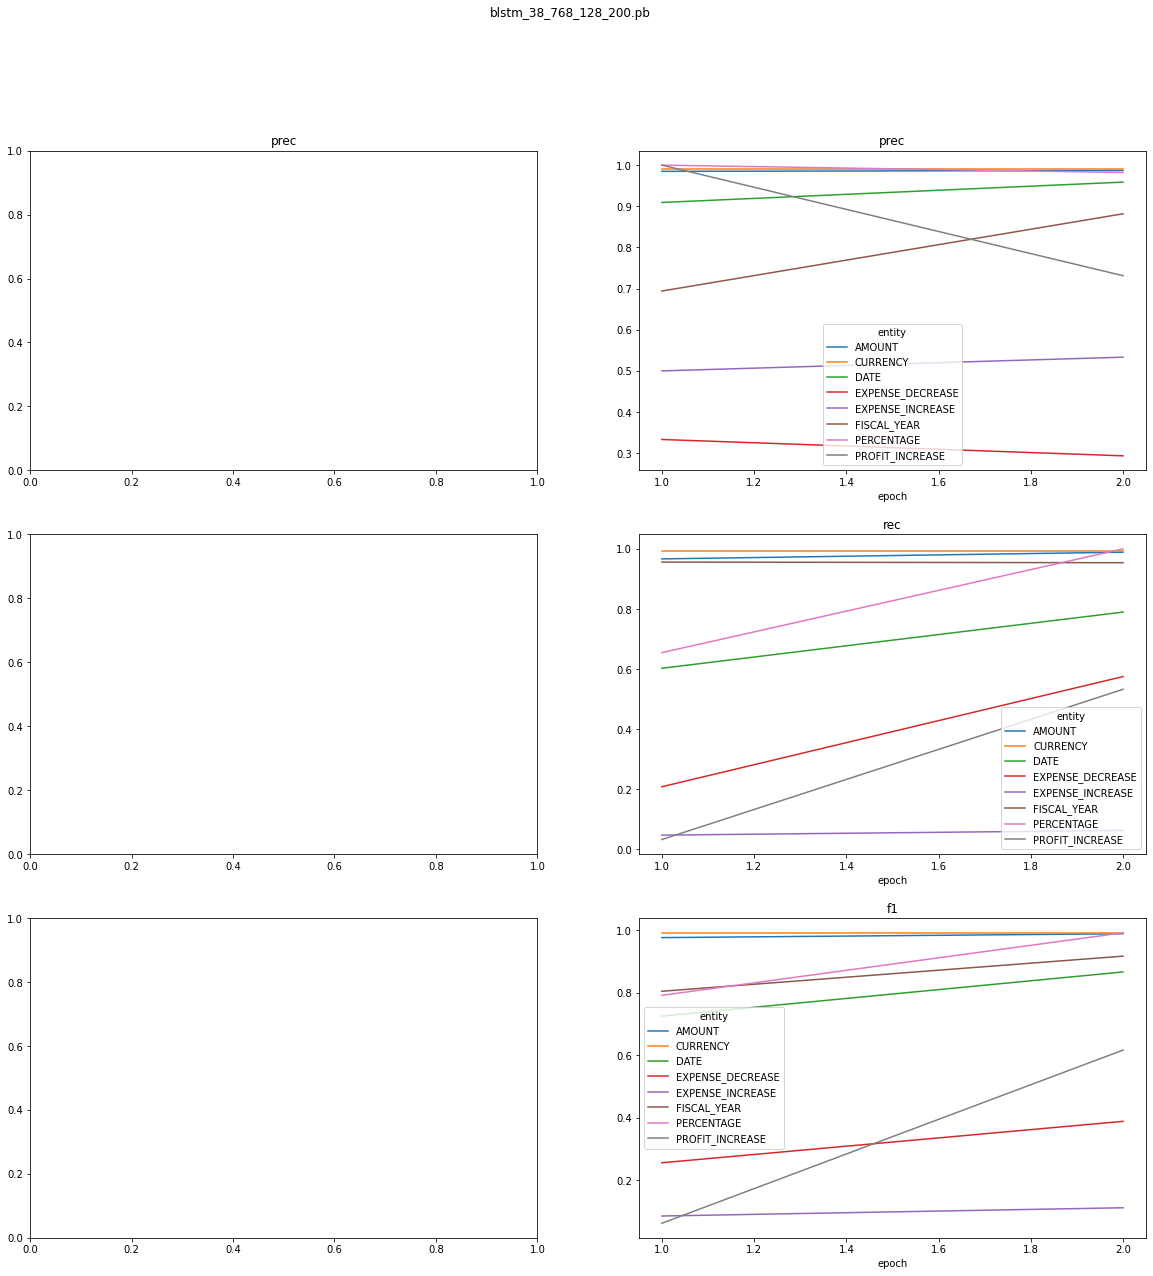

In [0]:
import ner_log_parser
%matplotlib inline

ner_log_parser.get_charts('/dbfs/ner_logs_best/'+log_files[0])

**Plotting Loss**

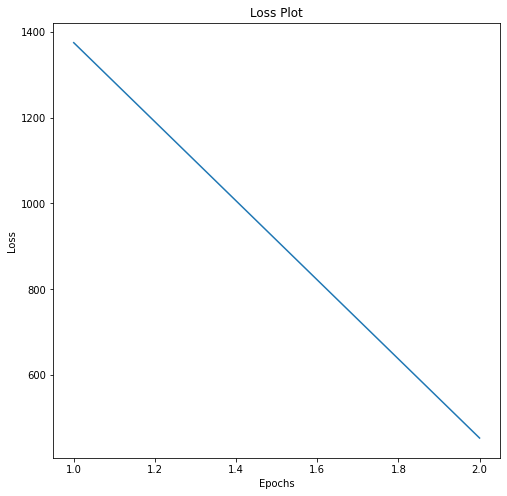

In [0]:
ner_log_parser.loss_plot('/dbfs/ner_logs_best/'+log_files[0])

###📌 Saving the trained model

In [0]:
ner_model.stages

Out[32]: [LegalNerModel_dbb6233bb863]

In [0]:
ner_model.stages[-1].write().overwrite().save('dbfs:/databricks/driver/models/NER_bert_e5_b32')

##📌 Prediction Pipeline

In [0]:
document = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

textSplitter = legal.TextSplitter()\
    .setInputCols(['document'])\
    .setOutputCol('sentence')

token = nlp.Tokenizer()\
    .setInputCols(['sentence'])\
    .setOutputCol('token')

roberta_embeddings = nlp.RoBertaEmbeddings.pretrained("roberta_embeddings_legal_roberta_base","en") \
    .setInputCols(["sentence", "token"]) \
    .setOutputCol("embeddings") \
    .setMaxSentenceLength(512)
  
# load trained model
loaded_ner_model = legal.NerModel.load("dbfs:/databricks/driver/models/NER_bert_e5_b32")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner")

converter = nlp.NerConverter()\
    .setInputCols(["document", "token", "ner"])\
    .setOutputCol("ner_span")

ner_prediction_pipeline = nlp.Pipeline(stages = [
                                            document,
                                            textSplitter,
                                            token,
                                            roberta_embeddings,
                                            loaded_ner_model,
                                            converter
                                            ])

roberta_embeddings_legal_roberta_base download started this may take some time.
Approximate size to download 447.2 MB
[ | ][OK!]

In [0]:
empty_data = spark.createDataFrame([['']]).toDF("text")

prediction_model = ner_prediction_pipeline.fit(empty_data)

In [0]:
text = """ARTICLE II ENGAGEMENT OF ZEBRA BRAZIL 6"""

sample_data = spark.createDataFrame([[text]]).toDF("text")

sample_data.show(truncate=False)

+---------------------------------------+
text |
+---------------------------------------+
ARTICLE II ENGAGEMENT OF ZEBRA BRAZIL 6|
+---------------------------------------+

In [0]:
%%time
preds = prediction_model.transform(sample_data)

preds.select(F.explode(F.arrays_zip(preds.ner_span.result,
                                    preds.ner_span.metadata)).alias("entities")) \
      .select(F.expr("entities['0']").alias("chunk"),
              F.expr("entities['1'].entity").alias("entity")).show(truncate=False)

+------------+------+
chunk |entity|
+------------+------+
ZEBRA BRAZIL|PARTY |
+------------+------+

CPU times: user 35.1 ms, sys: 29.4 ms, total: 64.6 ms
Wall time: 3.13 s

In [0]:
light_model = nlp.LightPipeline(prediction_model)

In [0]:
%%time
text = """ARTICLE II ENGAGEMENT OF ZEBRA BRAZIL 6"""

result_ann = light_model.annotate(text)

list(zip(result_ann['token'], result_ann['ner']))

CPU times: user 27.9 ms, sys: 15.3 ms, total: 43.2 ms
Wall time: 2.59 s
Out[39]: [('ARTICLE', 'O'),
 ('II', 'O'),
 ('ENGAGEMENT', 'O'),
 ('OF', 'O'),
 ('ZEBRA', 'B-PARTY'),
 ('BRAZIL', 'I-PARTY'),
 ('6', 'O')]

In [0]:
%%time
import pandas as pd

result = light_model.fullAnnotate(text)

ner_df= pd.DataFrame([(int(x.metadata['sentence']), x.result, x.begin, x.end, y.result) for x,y in zip(result[0]["token"], result[0]["ner"])], 
                      columns=['sent_id','token','start','end','ner'])
ner_df

CPU times: user 25.1 ms, sys: 15.1 ms, total: 40.2 ms
Wall time: 412 ms
Out[40]:

,sent_id,token,start,end,ner
0,0,ARTICLE,0,6,O
1,0,II,8,9,O
2,0,ENGAGEMENT,11,20,O
3,0,OF,22,23,O
4,0,ZEBRA,25,29,B-PARTY
5,0,BRAZIL,31,36,I-PARTY
6,0,6,38,38,O


###📚 Highlight Entities

In [0]:
from sparknlp_display import NerVisualizer

result = result[0]
visualiser = nlp.viz.NerVisualizer()
displayHTML(visualiser.display(result, label_col='ner_span', document_col='document', return_html = True))

ARTICLE II ENGAGEMENT OF ZEBRA BRAZIL PARTY 6